# NIH dataset exploratory data analysis

This notebooks proposes an exploration of the NIH dataset that can be found on kaggle : https://www.kaggle.com/nih-chest-xrays/data.
The objective is to find preliminary informations that may allow the build of an appropriate model for the detection of Pneumonia on xrays.

In [2]:
# Importing libraries

import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from scipy.stats import norm
from random import sample


## Data Cleaning

In [3]:
# Building the dataframe

df = pd.read_csv('/data/Data_Entry_2017.csv')
df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [4]:
# Adding the column path
pths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(pths.get)

# The column 'Unnamed: 11' is empty, let's drop it

df = df.drop('Unnamed: 11', axis=1)

# The image resolution is not a pertinent information for modeling, so let's also drop the last 4 columns

df = df.drop(['OriginalImage[Width', 
                               'Height]', 
                               'OriginalImagePixelSpacing[x', 
                               'y]'],
                               axis=1)

In [5]:
# Some patients have erronous ages
err_age = df[df['Patient Age'] > 100]
err_age

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,/data/images_003/images/00005567_000.png
46965,00011973_002.png,Edema,2,11973,414,M,AP,/data/images_006/images/00011973_002.png
48284,00012238_010.png,No Finding,10,12238,148,M,PA,/data/images_006/images/00012238_010.png
55742,00013950_000.png,No Finding,0,13950,148,M,PA,/data/images_007/images/00013950_000.png
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,/data/images_007/images/00014520_026.png
62929,00015558_000.png,No Finding,0,15558,149,M,PA,/data/images_007/images/00015558_000.png
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,/data/images_008/images/00018366_044.png
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,/data/images_009/images/00019346_000.png
84810,00020900_002.png,No Finding,2,20900,411,M,AP,/data/images_009/images/00020900_002.png
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,/data/images_010/images/00021047_002.png


In [6]:
# Some of the wrong ages concern patients that have several # follow-ups, 
# in those cases we replace the erronous age with an age in another follow-ups

for ind in err_age.index:
    if err_age.loc[ind]['Follow-up #'] > 0:
        df.at[ind, 'Patient Age'] = df.at[ind-1, 'Patient Age']

for ind in err_age.index:
    if df.at[ind, 'Patient ID'] == df.at[ind+1, 'Patient ID']:
        df.at[ind, 'Patient Age'] = df.at[ind+1, 'Patient Age']

# For the remaining values we will replace the age by the mean

mean_age = df['Patient Age'].mean()
for ind in err_age.index:
    df.at[ind, 'Patient Age'] = mean_age

In [7]:
# Checking that there are no anomalies concerning the gender and the view position columns
print(df['Patient Gender'].unique())
print(df['View Position'].unique())

['M' 'F']
['PA' 'AP']


In [8]:
# Doing a 'hot-encoding' procedure for the categorical values in the 'Finding Labels' column will make the exploration easier

unique_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_findings = [x for x in unique_findings if len(x)>0]

print('All Labels ({}): {}'.format(len(unique_findings), unique_findings))
for c_label in unique_findings:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,/data/images_001/images/00000001_000.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,/data/images_001/images/00000001_001.png,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,/data/images_001/images/00000001_002.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,/data/images_001/images/00000002_000.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,/data/images_001/images/00000003_000.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,/data/images_001/images/00000003_001.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,/data/images_001/images/00000003_002.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,/data/images_001/images/00000003_003.png,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,/data/images_001/images/00000003_004.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,/data/images_001/images/00000003_005.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data exploration
### Basic Statistics

In [9]:
# Statistics and Patient demographic data
# Notice that we will consider each xray as a different case

num_xrays = len(df)
num_uniq_pat = df['Patient ID'].nunique()
num_findings = len(unique_findings)
num_xrays_pneum = len(df[df['Pneumonia'] == 1])

std_age = df['Patient Age'].std()
ratio_male = len(df[df['Patient Gender'] == 'M'])/num_xrays*100 
ratio_female = len(df[df['Patient Gender'] == 'F'])/num_xrays*100
list_viewposition = df['View Position'].unique()
ratio_viewpositionPA = len(df[df['View Position'] == 'PA'])/num_xrays*100 
ratio_viewpositionAP = len(df[df['View Position'] == 'AP'])/num_xrays*100 

mean_age_pneum = df[df['Pneumonia'] == 1]['Patient Age'].mean()
std_age_pneum = df[df['Pneumonia'] == 1]['Patient Age'].std()
ratio_male_pneum = len(df[(df['Patient Gender'] == 'M') & 
                                   (df['Pneumonia'] == 1)])/num_xrays_pneum *100
ratio_female_pneum = len(df[(df['Patient Gender'] == 'F') & 
                                     (df['Pneumonia'] == 1)])/num_xrays_pneum*100 
ratio_viewpositionPA_pneum = len(df[(df['Pneumonia'] == 1) & 
                                     (df['View Position'] == 'PA')])/num_xrays_pneum*100 
ratio_viewpositionAP_pneum = len(df[(df['Pneumonia'] == 1) & 
                                     (df['View Position'] == 'AP')])/num_xrays_pneum *100

In [10]:
print('Number of xrays :', num_xrays, "\n",
      'Number of unique Patients :', num_uniq_pat, "\n",
      'Number of Different findings :', num_findings, "\n",
      'List of findings :', unique_findings, "\n",
      'List of view positions:',list_viewposition, "\n",
      'Number of Pneumonia cases :',num_xrays_pneum, "\n",
      'Number of non-Pneumonia cases:', num_xrays-num_xrays_pneum, "\n",
      'Proportion of case presenting a finding:', (num_xrays-len(df[df['No Finding'] == 1]))/num_xrays*100,"%\n\n",
      
      'Average of patients age :', mean_age,"\n",
      'Standard deviation of patients age :', std_age,"\n",
      'Proportion of Males:', ratio_male, "%\n", 
      'Proportion of Females:', ratio_female, "%\n",
      'Proportion of PA view position:',ratio_viewpositionPA, "%\n",
      'Proportion of AP view position:',ratio_viewpositionAP, "%\n\n",
      
      'Average age of patients presenting pneumonia :', mean_age_pneum,"\n",
      'Standard deviation of patients presenting pneumonia :', std_age_pneum,"\n",
      'Proportion of Males presenting pneumonia:', ratio_male_pneum, "%\n", 
      'Proportion of Females presenting pneumonia:', ratio_female_pneum, "%\n", 
      'Proportion of PA view position presenting pneumonia:',ratio_viewpositionPA_pneum, "%\n",
      'Proportion of AP view position presenting pneumonia:',ratio_viewpositionAP_pneum, "%\n")

Number of xrays : 112120 
 Number of unique Patients : 30805 
 Number of Different findings : 15 
 List of findings : ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 
 List of view positions: ['PA' 'AP'] 
 Number of Pneumonia cases : 1431 
 Number of non-Pneumonia cases: 110689 
 Proportion of case presenting a finding: 46.16393150196218 %

 Average of patients age : 46.8757670353193 
 Standard deviation of patients age : 16.596970792394206 
 Proportion of Males: 56.49304316803425 %
 Proportion of Females: 43.50695683196575 %
 Proportion of PA view position: 60.033892258294685 %
 Proportion of AP view position: 39.966107741705315 %

 Average age of patients presenting pneumonia : 44.671558350803636 
 Standard deviation of patients presenting pneumonia : 17.63296405248245 
 Proportion of Males presenting pneumonia: 58.56044723969253 

Our dataset presents 112120 xrays with 1431 wrays presenting a label "pneumonia" obtained with NLP algorithm (acc=90%).
This corresponds to 1.3% of the total dataset.
Please note that actually there are 30801 unique patients. For now we will consider each xray as a different case idependant of the others. 
Both view position are present in our dataset in big proportions for both pneumonia and non pneumonia case, the view position impact on pixel level assessment should be adressed.

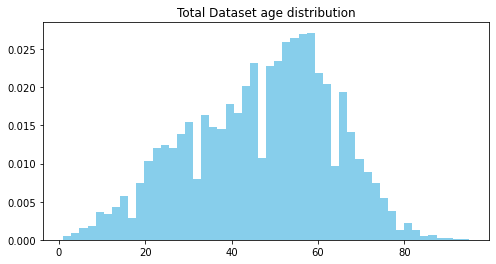

In [46]:
# Plotting the age distribution of the whole dataset

plt.figure(figsize=(8,4))
plt.hist(df['Patient Age'], bins=50, density=True, color='skyblue')
plt.title('Total Dataset age distribution')
plt.show()

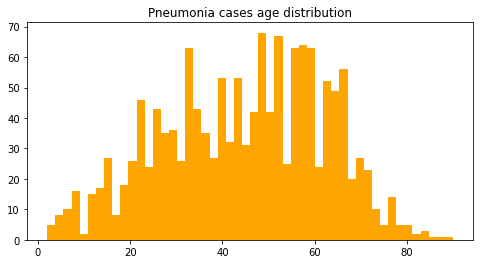

In [47]:
# Plotting the age distribution of pneumonia cases

plt.figure(figsize=(8,4))
plt.hist(df[df.Pneumonia==1]['Patient Age'], bins=50, color='orange')
plt.title('Pneumonia cases age distribution')
plt.show()

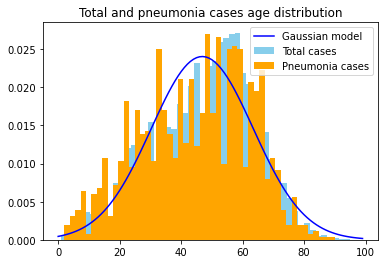

In [48]:
# Plotting the (normalized) age distribution of the entire population,
# a gaussian curve with similar parameters and
# age distribution of pneumonia cases 

x_axis = np.arange(0, 100, 1)
plt1 = plt.plot(x_axis, norm.pdf(x_axis,mean_age,std_age), color='blue')
plt2 = plt.hist(df['Patient Age'], bins=50, density=True, color='skyblue')
plt3 = plt.hist(df[df.Pneumonia==1]['Patient Age'], bins=50, density=True, color='orange')
plt.title('Total and pneumonia cases age distribution')
plt.legend(('Gaussian model', 'Total cases', 'Pneumonia cases'))
plt.show()

The age distribution of xrays presenting pneumonia is a bell shaped gaussian function with a mean of 44.7 and a standard deviation of 17.6. It follows very closely the age distribution of the whole dataset (mean = 46.8, std = 16.6).
This means that the age might not help to distinguish pneumonia from non pneumonia cases in our dataset.

### Distributions of diseases and comorbidities

Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64


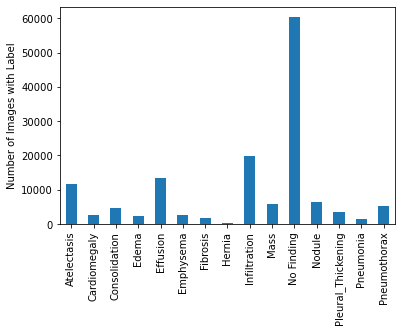

In [49]:
# Printing the frequency of all labels

print(df[unique_findings].sum()/num_xrays*100)
ax = df[unique_findings].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
plt.show()

Most of xrays presents no Findings. Xrays presenting pneumonia represent a very small precentage of the dataset. This will requires special attention during data preparation before the CNN training.

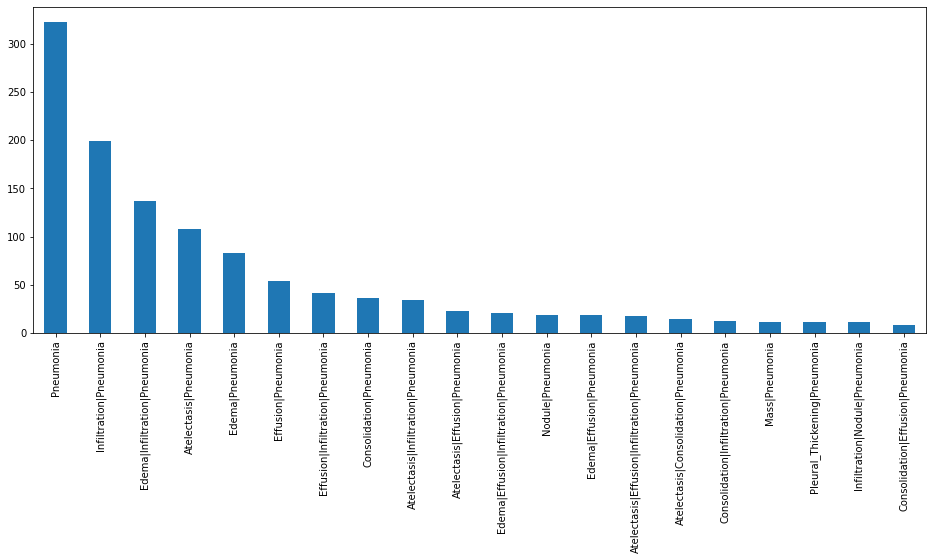

In [50]:
# Plotting the occurences of all findings in case of Pneumonia

plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')
plt.show()

Pneumonia is not always the only finding detected on xrays, pneumonia is frequently in presence of other comorbitidies such as Infiltration and Edema. Let's check their occurences with Pneumonia, label by label.

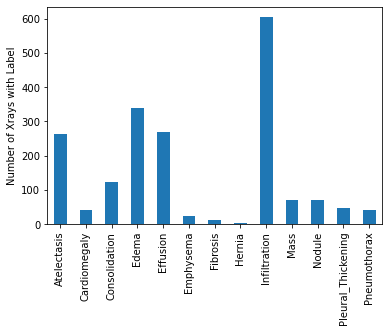

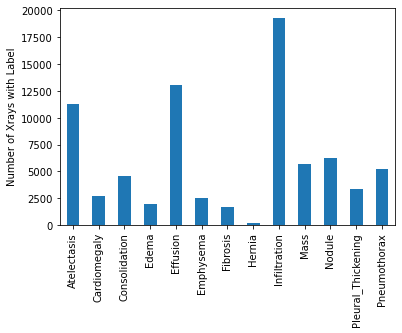

In [51]:
# Plotting the occurences of pneumonia-associated comorbidities in presence of pneumonia

comorbidities = [x for i,x in enumerate(unique_findings) if i!=13 and i!=10]
ax = df[df.Pneumonia==1][comorbidities].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Xrays with Label')
plt.show()

# Plotting the occurences of the labels in absence of pneumonia

comorbidities = [x for i,x in enumerate(unique_findings) if i!=13 and i!=10]
ax = df[df.Pneumonia==0][comorbidities].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Xrays with Label')
plt.show()

Pneumonia is frequently associated with Infiltration, Edema, Effusion, Atelectasis.
But they are not necessarly the best pneumonia-associated comorbidities to distinguish Pneumonia from other cases. 
Infiltration frequency is independent of the presence of pneumonia hence not an interesting feature to detect Pneumonia. Edema frequency rises up in presence of Pneumonia and may be a better feature to check in order to detect Pneumonia.

## Pixel Level assessment


After analyzing the xrays metadata we can now start pixel level analysis of the xrays to have some preliminary results and build some intuition concerning pneumonia on xrays.

In [52]:
## Loading 'sample_labels.csv' data for pixel level assessments

sample_df = pd.read_csv('sample_labels.csv')
sample_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


In [53]:
pths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(pths.get)

In [54]:
# The image resolution is not a pertinent information for pneumonia cases modeling, so let's drop the last 4 columns

sample_df = sample_df.drop(['OriginalImageWidth', 
                               'OriginalImageHeight', 
                               'OriginalImagePixelSpacing_x', 
                               'OriginalImagePixelSpacing_y'],
                               axis=1)

# Let's do a 'hot-encoding' procedure for the categorical values of the 'Finding Labels' column to make the exploration easier
unique_findings = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_findings = [x for x in unique_findings if len(x)>0]

print('All Labels ({}): {}'.format(len(unique_findings), unique_findings))
for c_label in unique_findings:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,/data/images_001/images/00000013_005.png,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,/data/images_001/images/00000013_026.png,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,/data/images_001/images/00000017_001.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,/data/images_001/images/00000030_001.png,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,/data/images_001/images/00000032_001.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,/data/images_001/images/00000040_003.png,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,/data/images_001/images/00000042_002.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,/data/images_001/images/00000057_001.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,00000061_002.png,Effusion,2,61,077Y,M,PA,/data/images_001/images/00000061_002.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,/data/images_001/images/00000061_019.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6,00000042_002.png,No Finding,2,42,071Y,M,AP,/data/images_001/images/00000042_002.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


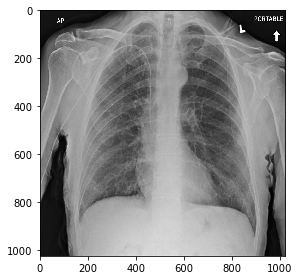

In [55]:
from skimage.io import imread, imshow

# Plotting a non pneumonia case xray
chest_norm = imread('/data/images_001/images/00000042_002.png')
img = imshow(chest_norm)
sample_df[sample_df.path == '/data/images_001/images/00000042_002.png']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5366,00028924_005.png,Pneumonia,5,28924,072Y,F,AP,/data/images_012/images/00028924_005.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


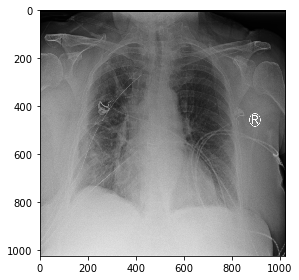

In [56]:
# Plotting a pneumonia case xray
chest_pneum = imread('/data/images_012/images/00028924_005.png')
img = imshow(chest_pneum)
sample_df[sample_df.path == '/data/images_012/images/00028924_005.png']

The difference between an xray presenting Pneumonia and a xray not presenting  Pneumonia is cleary not easy for an untrained eye.
Pneumonia can be detected on chest xrays presenting an opaque (white) spot on the lungs area.

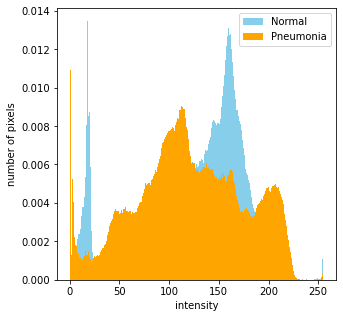

In [57]:
#intensity histogram of normal and penumonia chest xrays

plt.figure(figsize=(5,5))

plt.hist(chest_norm.ravel(),bins=256,color='skyblue', density=True)
plt.hist(chest_pneum.ravel(),bins =256,color='orange', density=True)
plt.legend(['Normal','Pneumonia'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

Detecting an opaque spot was extremely difficult on the two sample images. 
'Luckily' the shape of the pixel intensity distribution is clearly different for the normal and pneumonia xrays. 
The xray labeled with pneumonia presents peaks at 125 while the 'normal' xray presents a peaks at 175.
We can be optimistic about pixel level assessment for pneumonia detection.
We notice a peak at 0 and almost no signal passing for both images : it corresponds to the background. We will Ignore the signals less than 25.

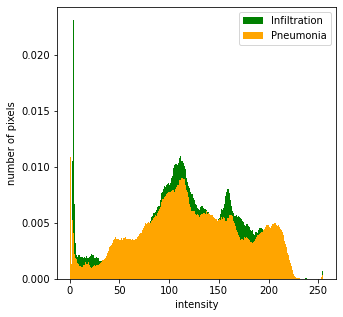

In [58]:
#intensity histogram of Infiltraton case

chest_infiltr = imread('/data/images_001/images/00000181_017.png')
plt.figure(figsize=(5,5))

plt.hist(chest_infiltr.ravel(),bins=256,color='green', density=True)
plt.hist(chest_pneum.ravel(),bins =256,color='orange', density=True)
plt.legend(['Infiltration','Pneumonia'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

Choosing infiltration as a third case we notice a peak at approximatively 125 like pneumonia. And the distribution is close to pneumonia case distribution. This may cause problems to detect pneumonia by analizing only peaks.

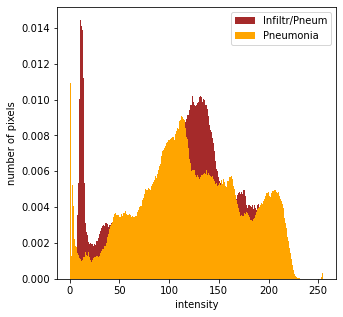

In [59]:
#intensity histogram of Infiltraton/Pneumonia case

chest_infiltr_pneum = imread('/data/images_008/images/00017504_062.png')
plt.figure(figsize=(5,5))

plt.hist(chest_infiltr_pneum.ravel(),bins=256,color='brown', density=True)
plt.hist(chest_pneum.ravel(),bins =256,color='orange', density=True)
plt.legend(['Infiltr/Pneum','Pneumonia'])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

The signal of a pneumonia/infiltration case has approximatively the same shape as pneumonia alone. But we notice that the peak at 125 shifts when we have pneumonia and infiltration.
This means that pixel intensity is not a linear effect of  or that the whole shift is due to apparatus that took the xray radio (the peak at 0 and 125 are shifted in the same direction).
Standardizing intensity and summing several signals may help to attenuates noise and apparatus effects.

In [60]:
# Appending non pneumonia images

max_count = 100

norm_intensities = np.zeros(shape=(max_count, 1024,1024))
counter = 0
    
for i in sample(df[df['No Finding'] == 1]['path'].tolist(), max_count):
    img = imread(i, as_gray=True)
#    img = img/img.std()
    norm_intensities[counter] = img
    counter +=1

In [61]:
# Removing the background induced peak at 0 and centralizing the distribution

img_mask = (norm_intensities > 25 )
norm_intensities = norm_intensities[img_mask] 
#norm_intensities -= norm_intensities.mean()

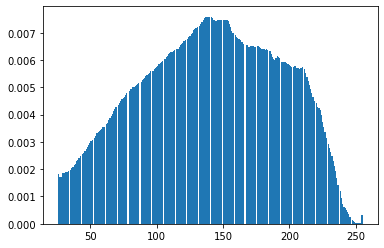

In [62]:
# Plotting the resulting distribution

fig = plt.hist(norm_intensities.flatten(), bins=255, density=True)

In [63]:
# Appending a set of pneumonia cases

pneum_intensities = np.empty(shape=(max_count, 1024, 1024))
counter = 0

for i in sample(df[df['Finding Labels'] == 'Pneumonia']['path'].tolist(), max_count):
    img = imread(i, as_gray=True)
#    img = img/img.std()
    pneum_intensities[counter] = img
    counter +=1   

In [64]:
# Removing the background induced peak at 0 and centralizing the distribution

img_mask = (pneum_intensities > 25)
pneum_intensities = pneum_intensities[img_mask] 
##pneum_intensities -= pneum_intensities.mean()

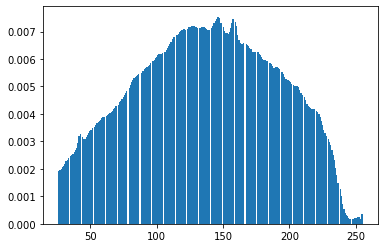

In [65]:
# Plotting the resulting distribution

x = plt.hist(pneum_intensities,bins=255, density=True)

In [66]:
# Determining the peak intensity

import scipy

norm_peak = scipy.stats.mode(norm_intensities)[0][0]
pneum_peak = scipy.stats.mode(pneum_intensities)[0][0]
print(norm_peak, pneum_peak)

141.0 147.0


In [81]:
# Testing the pneumonia prediction based on peak intensity

tn, fp = 0, 0

max_count = 30

for i in sample(sample_df[sample_df['No Finding'] == 1]['path'].tolist(), max_count):  
    img = imread(i, as_gray=True)
#    img = img/img.std()
    img_mask = (img > 25)
    img = img[img_mask]
       
    normal_delta = scipy.stats.mode(img)[0][0] - norm_peak
    pneum_delta = scipy.stats.mode(img)[0][0] - pneum_peak
    
    if (np.abs(normal_delta) < np.abs(pneum_delta)):
        tn = tn + 1
    else:
        fp = fp +1

In [82]:
tp, fn = 0, 0

for i in sample(df[df['Pneumonia'] == 1]['path'].tolist(), max_count):  
    img = imread(i, as_gray=True)
#    img = img/img.std()
    img_mask = (img > 25)
    img = img[img_mask]
    normal_delta = scipy.stats.mode(img)[0][0] - norm_peak
    pneum_delta = scipy.stats.mode(img)[0][0] - pneum_peak
    
    if (np.abs(normal_delta) < np.abs(pneum_delta)):
        fn = fn + 1
    else:
        tp = tp +1

In [83]:
# Printing the confusion matrix

print('|', tp, '|', fp,'|')
print('-----------')
print('|', fn, '|', tn,'|')

| 14 | 20 |
-----------
| 16 | 10 |


Checking now different performance metrics

In [84]:
precision = tp/(tp + fp)
precision

0.4117647058823529

In [85]:
recall = tp/(tp + fn)
recall

0.4666666666666667

In [86]:
f1 = 2*precision*recall/(precision + recall)
f1

0.43749999999999994

All of the  statistical performance are low : a pixel level assessment and peak comparison may be not enough to predict pneumonia.